### Import necessary packages

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(readxl)
library(httr)
library(jsonlite)
library(ggplot2)
library(GGally)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

## Preliminary Exploratory Data Analysis

#### Download Pulsar Data

In [2]:
# Download Pulsar data without kaggle helpers
PULSAR_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip"
GET(PULSAR_URL, write_disk(tf <- tempfile(fileext = ".zip")))

# Unzip the tempfile and read the csv inside it, renaming the columns as below
# then mutate the target class to a meaningful value for a human and convert to a factor
pulsar_data <- read_csv(unz(tf, "HTRU_2.csv"), col_names = c("mean_ip", 
                                                             "std_ip", 
                                                             "excess_kurtosis_ip", 
                                                             "skewness_ip", 
                                                             "mean_dm_snr", 
                                                             "std_dm_snr", 
                                                             "excess_kurtosis_dm_snr", 
                                                             "skewness_dm_snr", 
                                                             "target_class")) %>% 
                 mutate(target_class = as_factor(case_when(
                                                target_class == 1 ~ "pulsar",
                                                TRUE ~ "other")))  # serves the same purpose as a default case in a switch statement 
# unlink/remove the temporary file
unlink(tf)

# preview the data
pulsar_data %>% head(5)

Response [https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip]
  Date: 2021-07-21 20:28
  Status: 200
  Content-Type: application/x-httpd-php
  Size: 1.56 MB
<ON DISK>  /tmp/RtmpKO578p/file27036c1bf60.zipNULL

Parsed with column specification:
cols(
  mean_ip = col_double(),
  std_ip = col_double(),
  excess_kurtosis_ip = col_double(),
  skewness_ip = col_double(),
  mean_dm_snr = col_double(),
  std_dm_snr = col_double(),
  excess_kurtosis_dm_snr = col_double(),
  skewness_dm_snr = col_double(),
  target_class = col_double()
)



mean_ip,std_ip,excess_kurtosis_ip,skewness_ip,mean_dm_snr,std_dm_snr,excess_kurtosis_dm_snr,skewness_dm_snr,target_class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,other
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,other
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,other
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,other
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,other


#### Raw data summary

In [3]:

sum(is.na(pulsar_data))
min(pulsar_data %>% select(mean_ip))
max(pulsar_data %>% select(mean_ip))

[1] 0

[1] 5.8125

[1] 192.6172

#### Processing Recipe

In [17]:
pulsar_recipe <- recipe(target_class ~ mean_ip + std_ip + excess_kurtosis_ip + skewness_ip + skewness_dm_snr, data = pulsar_data) %>% 
                    na.omit() %>% 
                    step_scale(all_predictors()) %>% 
                    step_center(all_predictors())

pulsar_recipe_all <- recipe(target_class ~ ., data = pulsar_data) %>% 
                    na.omit() %>% 
                    step_scale(all_predictors()) %>% 
                    step_center(all_predictors())

pulsar_scaled <- pulsar_recipe %>% 
                    prep() %>% 
                    bake(pulsar_data)

pulsar_scaled_all <- pulsar_recipe_all %>% 
                    prep() %>% 
                    bake(pulsar_data)

pulsar_scaled %>%  head(5)


mean_ip,std_ip,excess_kurtosis_ip,skewness_ip,skewness_dm_snr,target_class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1.1492849,1.3347944,-0.66955083,-0.4004478,-0.2874301,other
-0.3341589,1.8022150,-0.01178443,-0.3705251,0.2115755,other
-0.3143634,-1.0532928,-0.14522850,-0.1165896,-0.3913625,other
1.0006664,1.5532110,-0.51339427,-0.3901672,-0.4812869,other
-0.8713781,-0.8588548,0.11560548,-0.1048632,1.3867553,other


#### Split the scaled data into training (80%) and testing (20%) subsets

In [10]:
set.seed(1) # set the random seed so that sample_frac selects the same rows each run
pulsar_training = pulsar_scaled %>% sample_frac(0.8)

# use dplyr's anti_join to maintain data exclusivity between the test and training subsets
pulsar_testing = anti_join(pulsar_scaled, pulsar_training)  # anti-join by all

Joining, by = c("mean_ip", "std_ip", "excess_kurtosis_ip", "skewness_ip", "skewness_dm_snr", "target_class")



In [11]:
stats_tibble <- tibble(num_nans = sum(is.na(pulsar_training)), 
                       num_pulsars = sum(pulsar_training$target_class == "pulsar"),
                       num_others = sum(pulsar_training$target_class == "other"))
stats_tibble
summary(pulsar_training)

num_nans,num_pulsars,num_others
<int>,<int>,<int>
0,1308,13010


    mean_ip              std_ip          excess_kurtosis_ip 
 Min.   :-4.103525   Min.   :-3.182360   Min.   :-2.212200  
 1st Qu.:-0.392251   1st Qu.:-0.606644   1st Qu.:-0.423681  
 Median : 0.157988   Median : 0.062268   Median :-0.240422  
 Mean   : 0.001413   Mean   : 0.001117   Mean   : 0.001196  
 3rd Qu.: 0.629577   3rd Qu.: 0.658919   3rd Qu.:-0.003065  
 Max.   : 3.178475   Max.   : 6.613743   Max.   : 7.134757  
  skewness_ip        skewness_dm_snr    target_class  
 Min.   :-0.577532   Min.   :-1.00301   other :13010  
 1st Qu.:-0.318020   1st Qu.:-0.65621   pulsar: 1308  
 Median :-0.255658   Median :-0.20245                 
 Mean   : 0.001968   Mean   : 0.00135                 
 3rd Qu.:-0.135926   3rd Qu.: 0.32978                 
 Max.   :10.754260   Max.   :10.19713                 

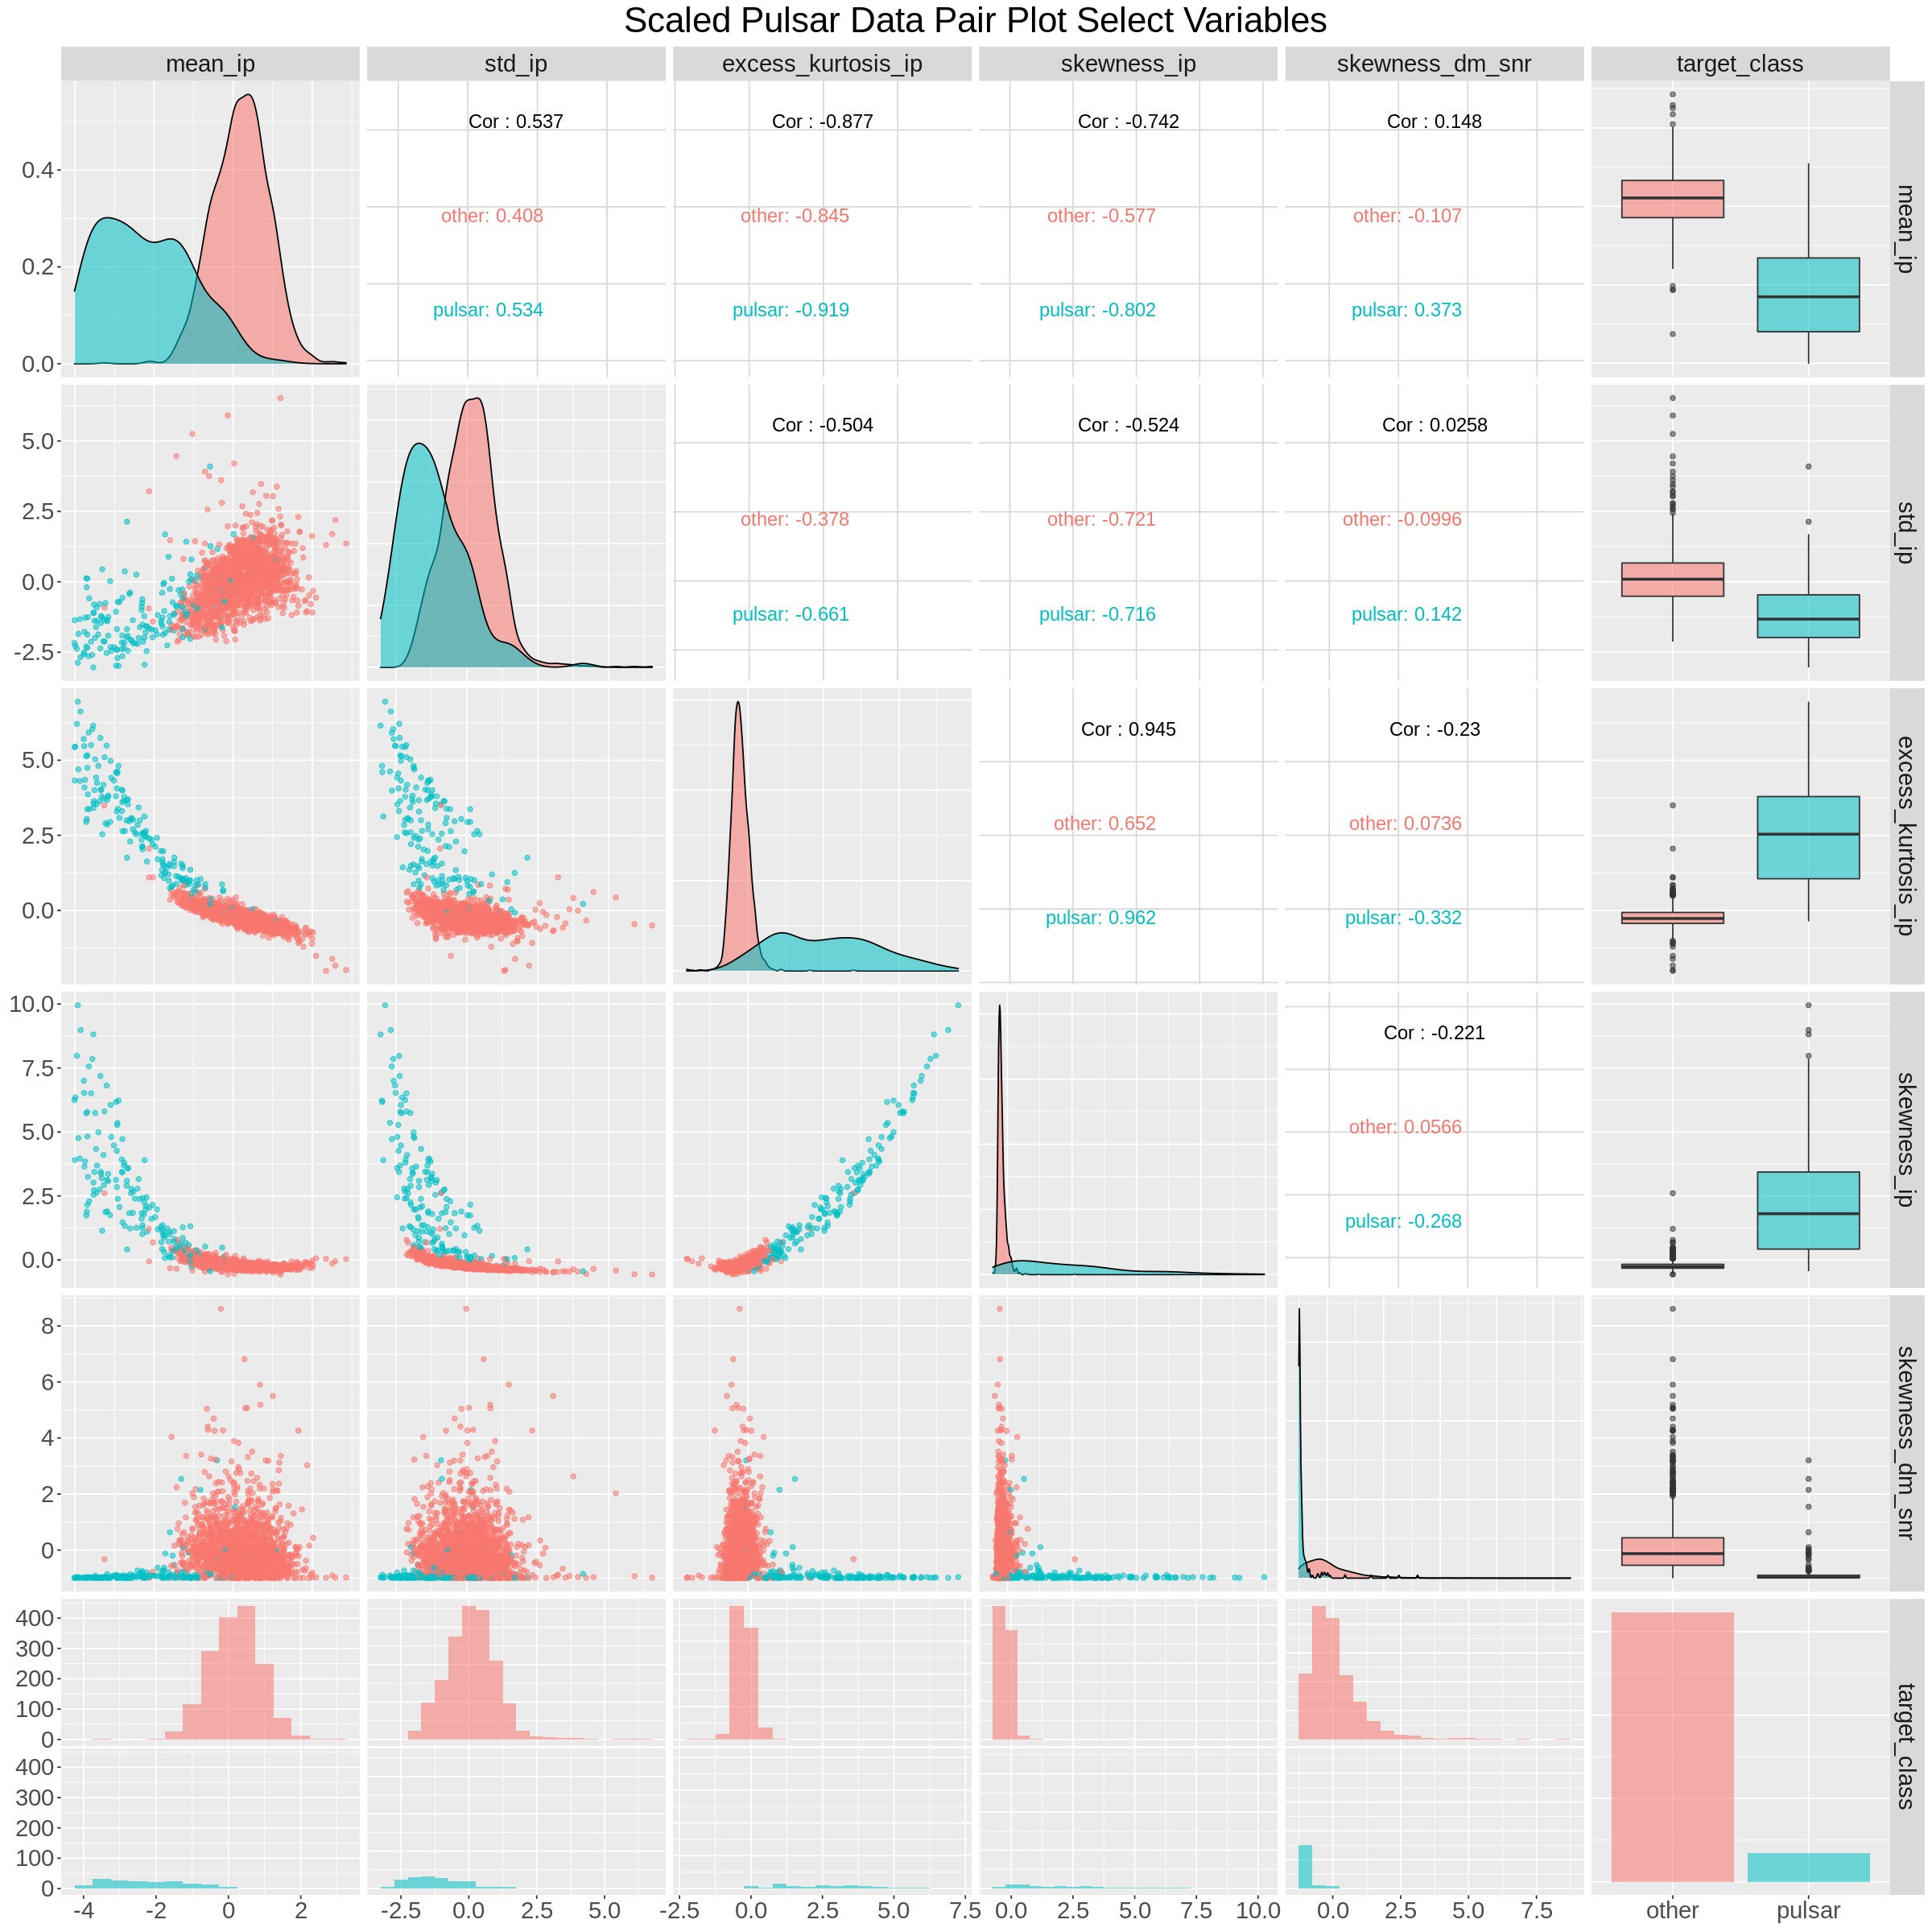

In [21]:
options(repr.plot.width = 20, repr.plot.height = 20)

# subset of the data for plotting
pulsar_scaled_subset <- pulsar_scaled %>% sample_frac(0.1) 

ggpairs(pulsar_scaled_subset,
           mapping = aes(color=target_class, alpha = 0.3),
           lower=list(combo=wrap("facethist", binwidth=0.5)),
           upper=list(continuous = wrap("cor", size=5))) +
        ggtitle("Scaled Pulsar Data Pair Plot Select Variables") +
        theme(text = element_text(size = 22),
              plot.title = element_text(hjust = 0.5))
        

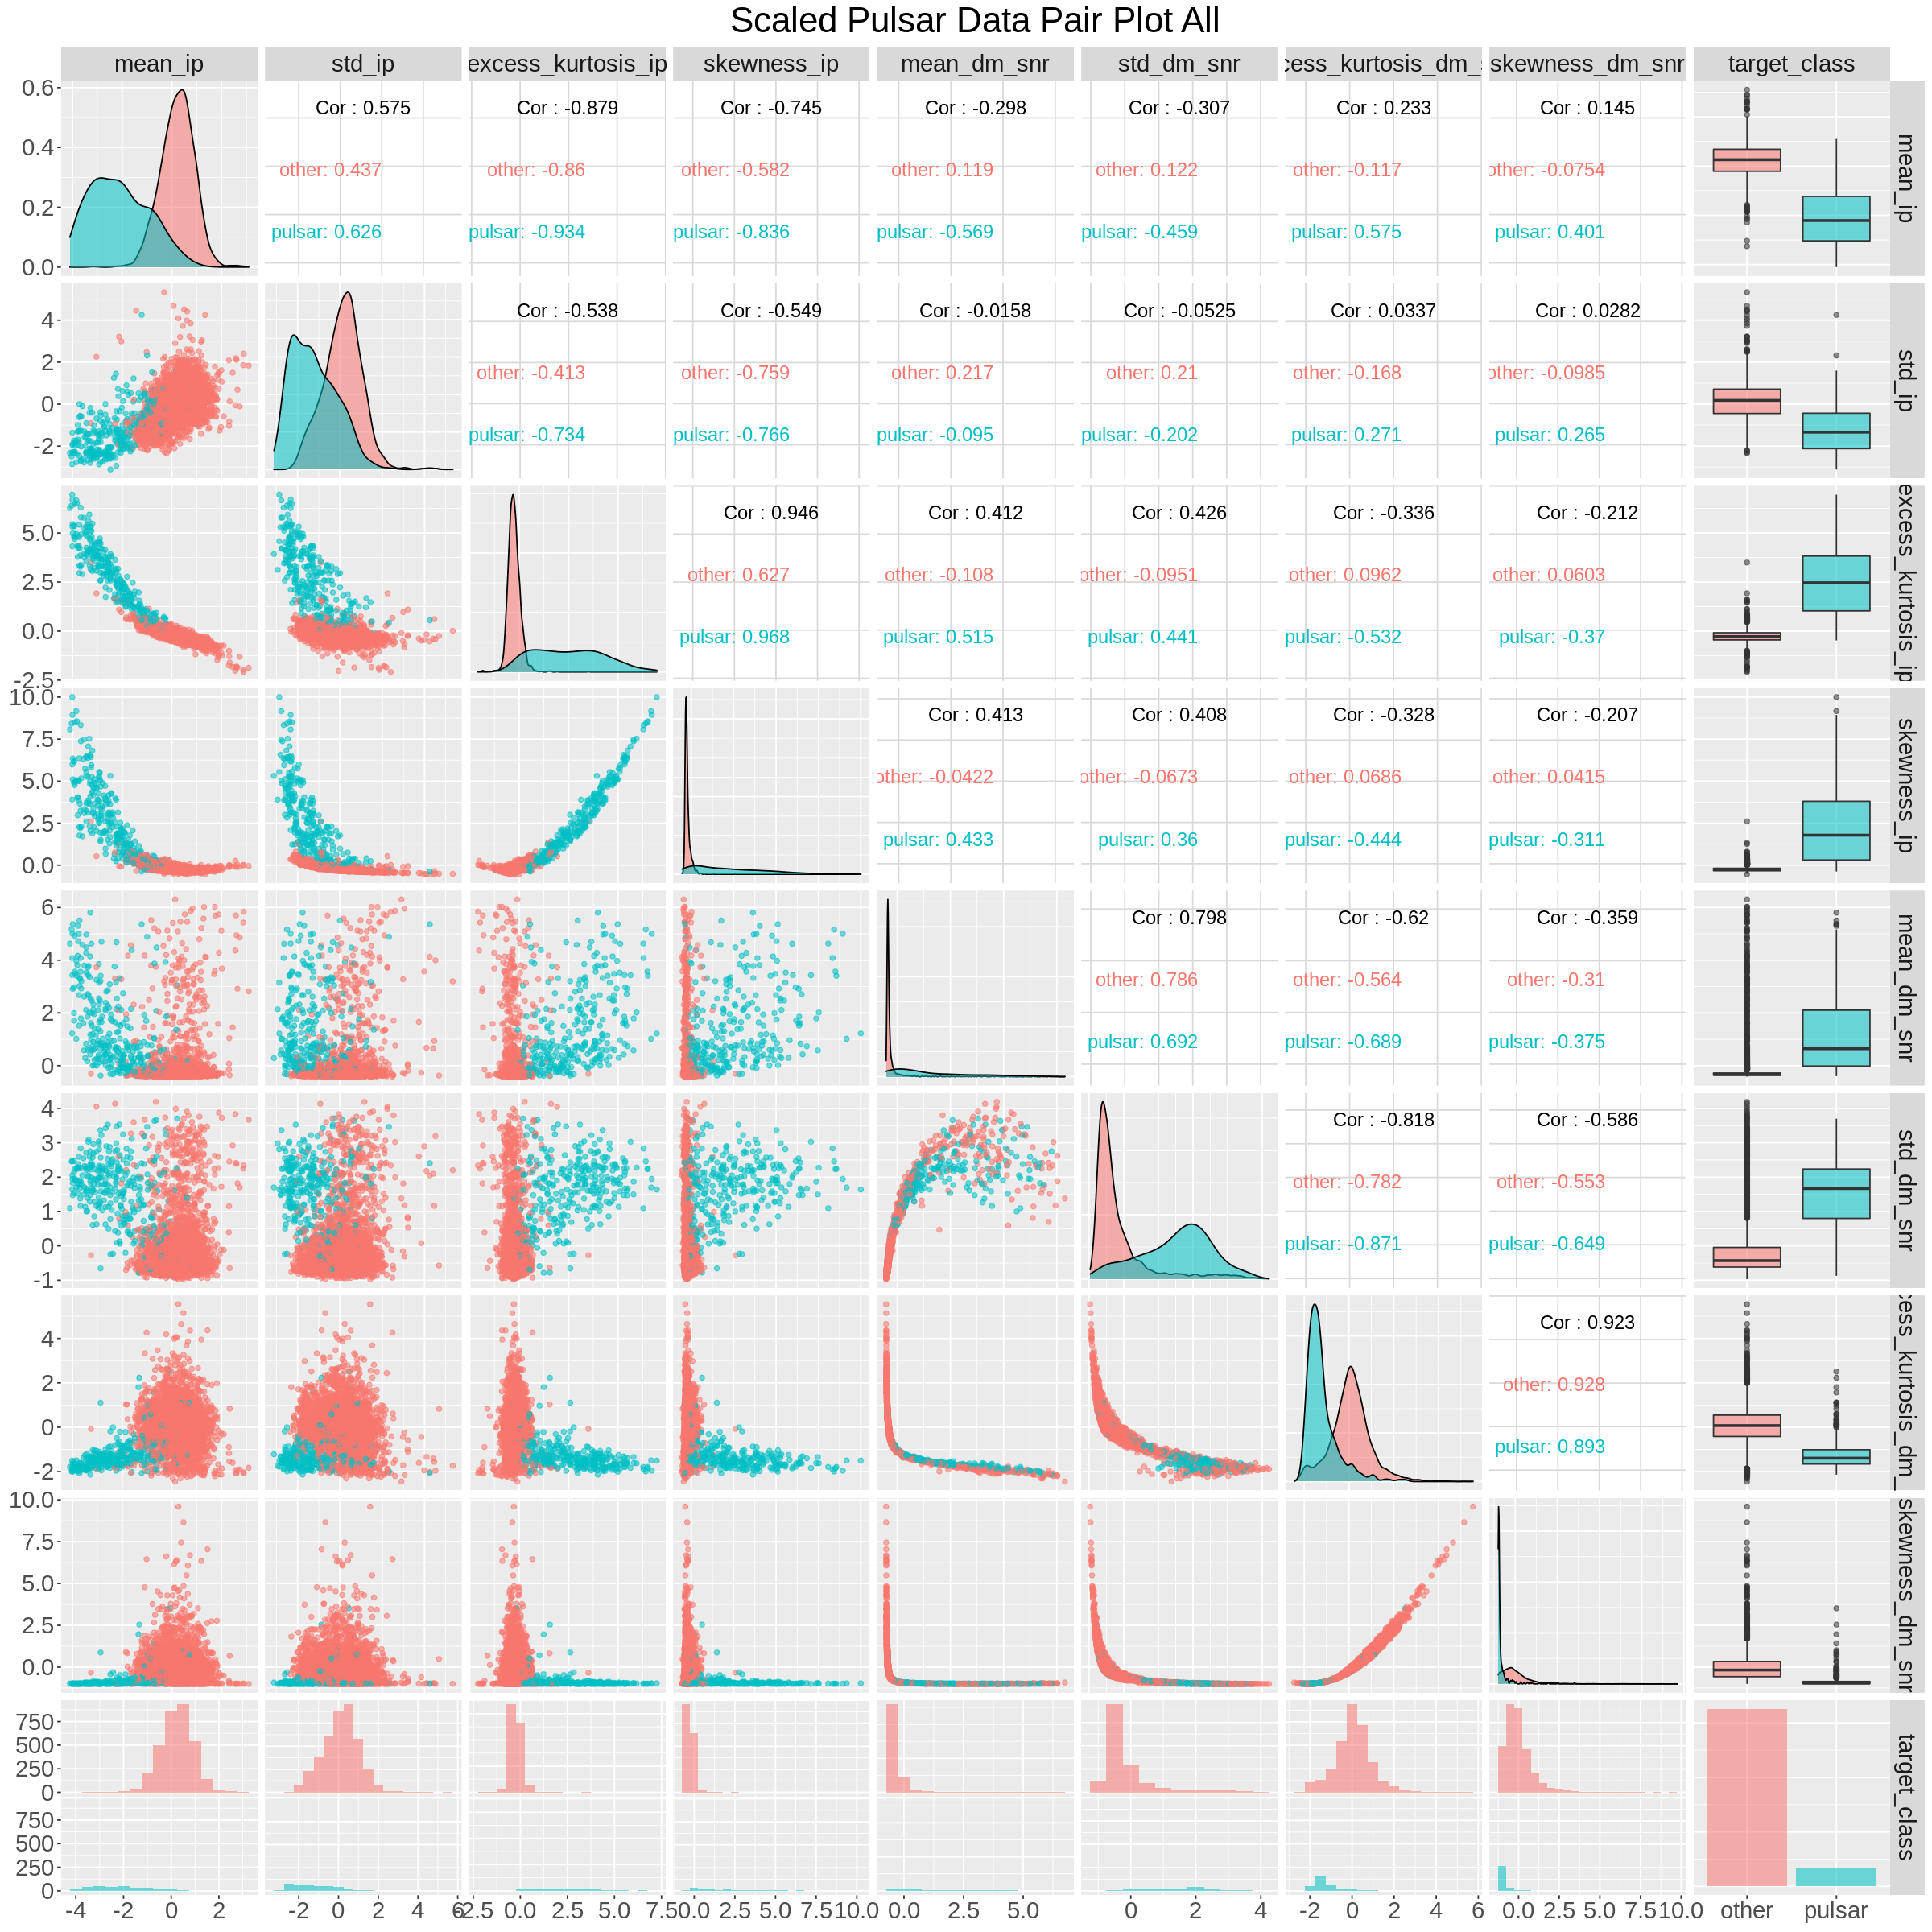

In [18]:

ggpairs(pulsar_scaled_all %>% sample_frac(0.2),
           mapping = aes(color=target_class, alpha = 0.3),
           lower=list(combo=wrap("facethist", binwidth=0.5)),
           upper=list(continuous = wrap("cor", size=5))) +
        ggtitle("Scaled Pulsar Data Pair Plot All") +
        theme(text = element_text(size = 22),
              plot.title = element_text(hjust = 0.5))